In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Define outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\,n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:\,nPercent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

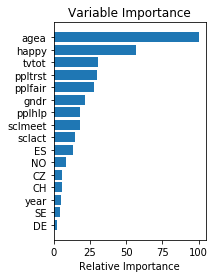

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

             idno      year     tvtot   ppltrst   pplfair    pplhlp     happy  \
idno     1.000000  0.002102  0.003963 -0.007523  0.007397  0.004484 -0.003065   
year     0.002102  1.000000 -0.031596 -0.001600  0.004283 -0.032901 -0.013378   
tvtot    0.003963 -0.031596  1.000000 -0.142422 -0.119277 -0.069080 -0.118598   
ppltrst -0.007523 -0.001600 -0.142422  1.000000  0.597506  0.459250  0.231533   
pplfair  0.007397  0.004283 -0.119277  0.597506  1.000000  0.480931  0.247755   
pplhlp   0.004484 -0.032901 -0.069080  0.459250  0.480931  1.000000  0.215323   
happy   -0.003065 -0.013378 -0.118598  0.231533  0.247755  0.215323  1.000000   
sclmeet -0.021376 -0.028502 -0.078864  0.122555  0.096501  0.080489  0.182944   
sclact   0.004323  0.012150 -0.092375  0.137491  0.128808  0.092673  0.192030   
gndr     0.010851  0.001355  0.017922 -0.029921  0.022251  0.042046 -0.022413   
agea     0.030051 -0.003520  0.257674 -0.029412  0.014724  0.040351 -0.042970   
partner -0.014931  0.018689 

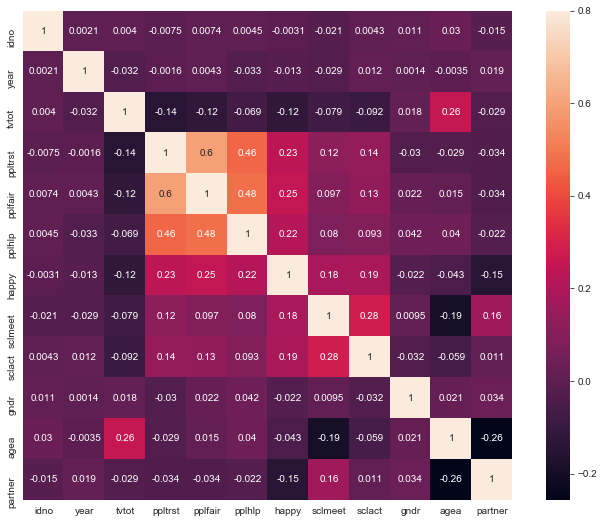

In [5]:
import seaborn as sns
sns.set_style('white')

# Let's see how our current features correlate with one another.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using Seaborn.
sns.heatmap(corrmat, annot=True, vmax=.8, square=True)
plt.show()

In [6]:
# Scale ppl values to combine in one feature.
means = df[['ppltrst', 'pplfair', 'pplhlp']].mean(axis=0)
stds = df[['ppltrst', 'pplfair', 'pplhlp']].std(axis=0)
df['trust_fair_help'] = ((df[['ppltrst', 'pplfair', 'pplhlp']] - means) / stds).mean(axis=1)

# Check new correlations.
plotdf = df.loc[:, ['ppltrst', 'pplfair', 'pplhlp']]
plotdf['trust_fair_help'] = df['trust_fair_help']
corrmat2 = plotdf.corr()
print(corrmat2)

                  ppltrst   pplfair    pplhlp  trust_fair_help
ppltrst          1.000000  0.597506  0.459250         0.834442
pplfair          0.597506  1.000000  0.480931         0.843238
pplhlp           0.459250  0.480931  1.000000         0.787147
trust_fair_help  0.834442  0.843238  0.787147         1.000000


In [7]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,trust_fair_help
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0,0.191246
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0,0.020453
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0,1.090626
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0,0.321425
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0,0.170892


In [8]:
# Let's try changing the parameters:
# Increase n_estimators from 500 to 1000.
# Increast max_depth from 2 to 3.
# Change loss from deviance to exponential.
params2 = {'n_estimators': 1000,
          'max_depth': 3,
          'loss': 'exponential'}

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params2)
clf2.fit(X_train, y_train)

predict_train2 = clf2.predict(X_train)
predict_test2 = clf2.predict(X_test)

# Accuracy tables.
table_train2 = pd.crosstab(y_train, predict_train2, margins=True)
table_test2 = pd.crosstab(y_test, predict_test2, margins=True)

train_tI_errors2 = table_train2.loc[0.0,1.0] / table_train2.loc['All','All']
train_tII_errors2 = table_train2.loc[1.0,0.0] / table_train2.loc['All','All']

test_tI_errors2 = table_test2.loc[0.0,1.0] / table_test2.loc['All','All']
test_tII_errors2 = table_test2.loc[1.0,0.0] / table_test2.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors2, train_tII_errors2, test_tI_errors2, test_tII_errors2))

Training set accuracy:
Percent Type I errors: 0.031642116748499725
Percent Type II errors: 0.13693398799781778

Test set accuracy:
Percent Type I errors: 0.08220858895705521
Percent Type II errors: 0.17914110429447852
